In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
suffix = 'calendar_grosses_domestic_2023'

with open(f'rt_df_{suffix}.pkl', 'rb') as file:
    # Load the pickled object
    rt_raw = pickle.load(file)

with open(f'mojo_{suffix}.pkl', 'rb') as file:
    # Load the pickled object
    mojo_raw = pickle.load(file)


In [17]:
rt = rt_raw.copy()

In [14]:
mojo = mojo_raw.copy()

In [15]:
mojo = mojo[ ~( mojo['Release'].str.contains('re-release', case = False) | mojo['Release'].str.contains('anniversary', case = False) ) ]
mojo = mojo.drop(['Genre', 'Budget', 'Running Time'], axis = 1).rename(columns = {'Release':'movie_title'})
mojo.columns = [x.lower() for x in mojo.columns]
mojo[['gross', 'total gross']] = mojo[['gross', 'total gross']].apply(lambda x: x.str.replace(',', '').str.replace('$', ''))
mojo[['gross', 'total gross']] = mojo[['gross', 'total gross']].apply(lambda x: pd.to_numeric(x, errors='coerce'))


In [18]:
rt = rt.drop(['image', 'critics_consensus', 'rating', 'actors', 'genres', 'directors', 'synopsis'], axis = 1)

In [7]:
print(rt.columns)
mojo.columns
print(len(mojo))
len(rt)

Index(['movie_title', 'tomatometer', 'audience_score', 'weighted_score',
       'duration', 'year_released', 'url', 'num_of_reviews'],
      dtype='object')
189


162

In [20]:
## manually make some mappings
rt.loc[rt['movie_title'] == 'Ant-Man and The Wasp: Quantumania', 'movie_title'] = 'Ant-Man and the Wasp: Quantumania'
rt.loc[rt['movie_title'] == 'Big George Foreman: The Miraculous Story of the Once and Future Heavyweight Champion of the World', 'movie_title'] = 'Big George Foreman'
rt.loc[rt['movie_title'] == "Guy Ritchie's The Covenant", 'movie_title'] = "Guy Ritchie's the Covenant"
rt.loc[rt['movie_title'] == 'Operation Fortune: Ruse de guerre', 'movie_title'] = 'Operation Fortune: Ruse de Guerre'
rt.loc[rt['movie_title'] == 'Ruby Gillman, Teenage Kraken', 'movie_title'] = 'Ruby Gillman: Teenage Kraken'
rt.loc[rt['movie_title'] == 'TAYLOR SWIFT | THE ERAS TOUR', 'movie_title'] = 'Taylor Swift: The Eras Tour'
rt.loc[rt['movie_title'] == 'Gran Turismo: Based on a True Story', 'movie_title'] = 'Gran Turismo'
rt.loc[rt['movie_title'] == 'Expend4bles', 'movie_title'] = 'The Expendables 4'

merged = mojo.merge(rt, on = 'movie_title', how = 'outer').sort_values(by = 'rank')

## what is null gross but not in rt
# merged[ merged['gross'].isnull() & merged['tomatometer'].notnull() ] 

## what is null in rt but not in gross
# merged[ merged['gross'].notnull() & merged['tomatometer'].isnull() ]['movie_title']

merged.isnull().sum() # the remaining movies can't be scraped by the package

## big issues
# some fuzzy matching necessary
# re-releases
# some of these random things from 2022 in 2023 -- although for example avatar, maybe that's ok

rank              10
movie_title        0
gross             10
theaters          10
total gross       10
release date      10
distributor       10
estimated         10
tomatometer       38
audience_score    38
weighted_score    38
duration          38
year_released     38
url               38
num_of_reviews    38
dtype: int64

In [21]:
working = merged[merged['gross'].notnull() & merged['tomatometer'].notnull()]
working = working[working['gross'] < 2*10**8] # winsorize
# working = working[working['gross'] < 1*10**8]
working['theaters'] = pd.to_numeric(working['theaters'])
working['gross_per_theater'] = working['gross'] / working['theaters']
working['total_gross_per_theater'] = working['total gross'] / working['theaters']

In [25]:
len(working) # 136
# len(merged) # 219
# working[working['movie_title'].str.contains('Avatar')]
# merged[merged['movie_title'].str.contains('Avatar')]
# rt[rt['movie_title'].str.contains('avatar', case = False)]

143

In [26]:
def regress_and_plot(df, x_var, y_var, title = None):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(df[x_var], df[y_var])

    correlation = df[x_var].corr(df[y_var])
    
    # Display regression statistics
    print(f'Regression statistics:')
    print(f'Intercept: {intercept:.4f}')
    print(f'Slope: {slope:.4f}')
    print(f'R-squared: {r_value**2:.4f}')
    print(f'Correlation (Pearson\'s r): {correlation:.4f}')
    print(f'P-value: {p_value:.4f}')
    print(f'Standard error: {std_err:.4f}')

    # Plotting the scatter plot with regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=x_var, y=y_var, data=df, ci=None, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    if not title:
        plt.title(f'Scatter Plot with Regression Line: {y_var} vs {x_var}')
    else:
        plt.title(f'{title}')

    # Annotate the correlation coefficient on the plot
    plt.text(0.05, 0.95, f'Correlation (r): {correlation:.4f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.grid(True)
    plt.show()


In [27]:
working.columns
len(working)

143

Regression statistics:
Intercept: -41707656.4622
Slope: 973123.7880
R-squared: 0.0794
Correlation (Pearson's r): 0.2817
P-value: 0.0007
Standard error: 279133.0256


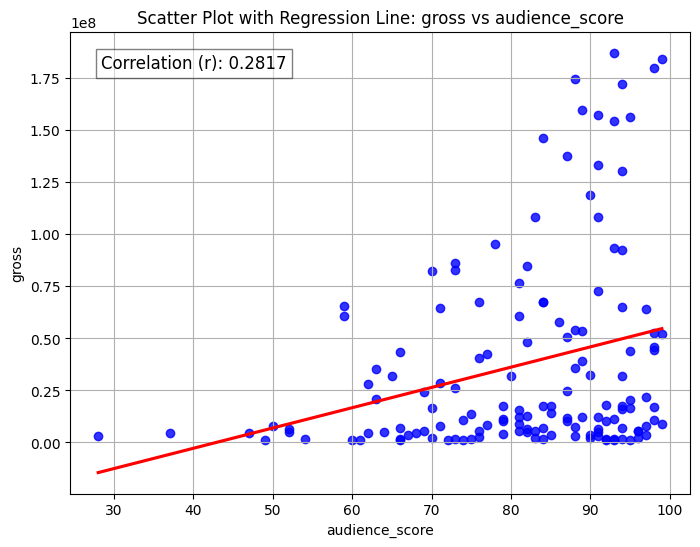

Regression statistics:
Intercept: -65219332.3098
Slope: 1379046.8649
R-squared: 0.0920
Correlation (Pearson's r): 0.3033
P-value: 0.0002
Standard error: 364849.1711


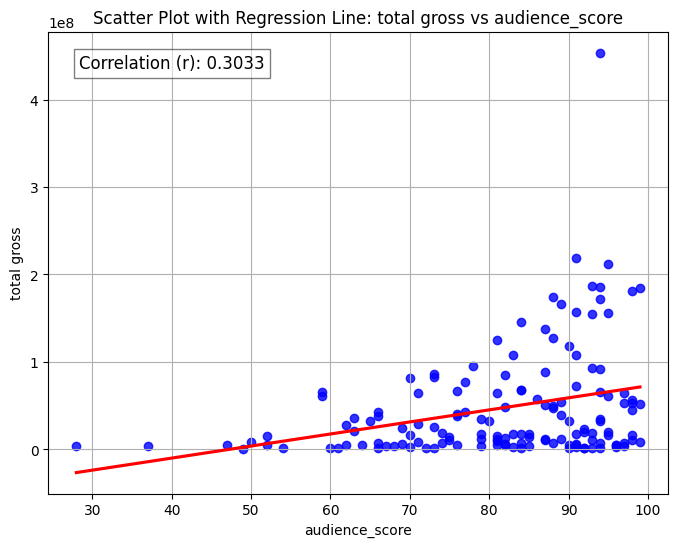

In [28]:
regress_and_plot(working, 'audience_score', 'gross')
regress_and_plot(working, 'audience_score', 'total gross')

Regression statistics:
Intercept: -3815.2088
Slope: 191.6371
R-squared: 0.0743
Correlation (Pearson's r): 0.2726
P-value: 0.0014
Standard error: 58.8748


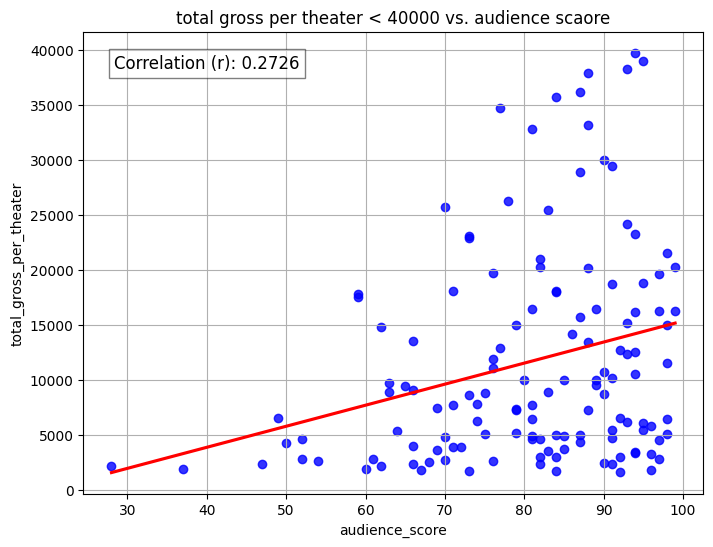

Regression statistics:
Intercept: -17607.6683
Slope: 399.0475
R-squared: 0.0974
Correlation (Pearson's r): 0.3121
P-value: 0.0001
Standard error: 102.3105


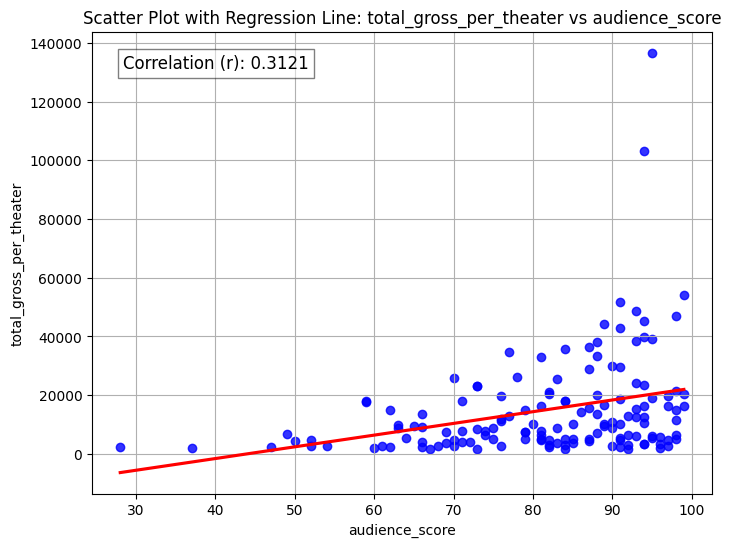

In [29]:
cutoff = 40000
regress_and_plot(working[working['total_gross_per_theater'] < cutoff], 'audience_score', 'total_gross_per_theater', title = f'total gross per theater < {cutoff} vs. audience score')
regress_and_plot(working, 'audience_score', 'total_gross_per_theater')

Regression statistics:
Intercept: 31196471.2415
Slope: 93452.6183
R-squared: 0.0020
Correlation (Pearson's r): 0.0450
P-value: 0.5933
Standard error: 174570.6584


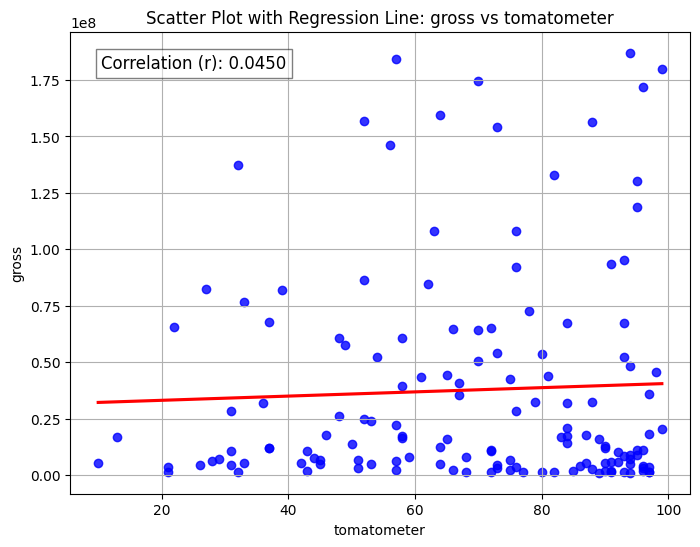

Regression statistics:
Intercept: 8233.0863
Slope: 48.5200
R-squared: 0.0093
Correlation (Pearson's r): 0.0964
P-value: 0.2520
Standard error: 42.1798


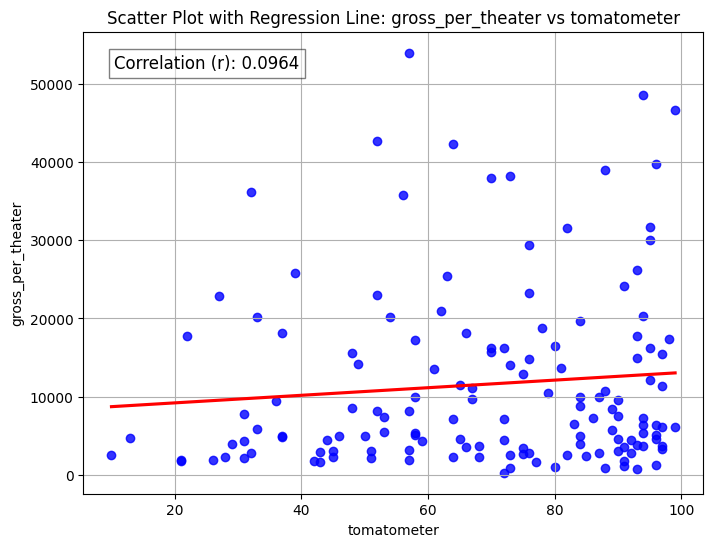

Regression statistics:
Intercept: 5300.6792
Slope: 139.8864
R-squared: 0.0332
Correlation (Pearson's r): 0.1821
P-value: 0.0295
Standard error: 63.6050


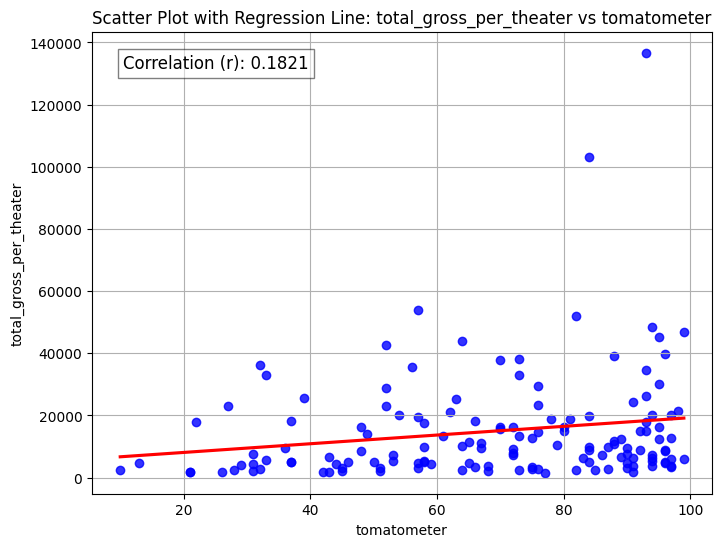

In [30]:
regress_and_plot(working, 'tomatometer', 'gross')
regress_and_plot(working, 'tomatometer', 'gross_per_theater')
regress_and_plot(working, 'tomatometer', 'total_gross_per_theater')

In [35]:
sum(working['rank'] < 50)
sum(working['rank'] > 50)
working.describe()

,rank,gross,theaters,total gross,tomatometer,audience_score,weighted_score,num_of_reviews,gross_per_theater,total_gross_per_theater
count,143.000000,1.430000e+02,143.000000,1.430000e+02,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,92.440559,3.762575e+07,2543.517483,4.720674e+07,68.797203,81.524476,72.685315,201.839161,11571.126851,14924.469199
std,54.696811,4.769143e+07,1219.077906,6.276906e+07,22.983631,13.805914,17.275082,108.448446,11565.409204,17654.027079
min,9.000000,9.720740e+05,115.000000,7.544830e+05,10.000000,28.000000,29.000000,21.000000,268.337087,1577.731740
25%,45.500000,4.821960e+06,1572.000000,5.986515e+06,52.000000,73.000000,59.500000,115.500000,3346.734819,4537.536384
50%,85.000000,1.575360e+07,2703.000000,2.035538e+07,73.000000,84.000000,75.000000,195.000000,7129.198141,9096.541207
75%,136.500000,5.385593e+07,3666.500000,6.446895e+07,90.000000,92.500000,87.000000,280.500000,16215.039549,18781.732632
max,199.000000,1.871318e+08,4600.000000,4.538291e+08,99.000000,99.000000,98.000000,474.000000,53995.228672,136677.723871


In [ ]:
# a = merged[merged['gross'].isnull() | merged['audience_score'].isnull()]['movie_title']
merged[merged['gross'].isnull()]['movie_title'] # list 1

# for i in merged[merged['audience_score'].isnull()]['movie_title']: # list 2
#     print(i)

## check what's in merged that's not in result
# result[result['best_match'].isin('')]

## check what's in result that's not in merged


In [ ]:
merged[merged['movie_title'].str.contains('Ant-Man', case = False, na = False)]

In [ ]:
import pandas as pd
from rapidfuzz import process, fuzz

# Sample DataFrames
# df1 = pd.DataFrame({'Title': ['Inception', 'The Matrix', 'Pulp Fiction', 'Avengers: Endgame']})
# df2 = pd.DataFrame({'Title': ['Inception', 'Matrix', 'Pulp Fiction', 'Avengers Endgame', 'The Lion King']})

# Function to perform fuzzy matching
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=1):
    """
    df_1: DataFrame with the first set of movie titles
    df_2: DataFrame with the second set of movie titles
    key1: Column name in df_1 to match on
    key2: Column name in df_2 to match against
    threshold: Score threshold for fuzzy matching (0-100)
    limit: Number of matches to return for each item
    """
    # Convert the column to a list for processing
    s = df_2[key2].tolist()
    
    # Apply the fuzzy matching process
    matches = df_1[key1].apply(lambda x: process.extract(x, s, scorer=fuzz.ratio, limit=limit))
    
    # Extract the top matches with score above the threshold
    df_1['matches'] = matches
    df_1['best_match'] = df_1['matches'].apply(lambda x: x[0][0] if x[0][1] >= threshold else None)
    df_1['match_score'] = df_1['matches'].apply(lambda x: x[0][1] if x[0][1] >= threshold else None)
    
    # Merge the dataframes on the best match
    merged_df = df_1.merge(df_2, left_on='best_match', right_on=key2, how='left', suffixes=('_df1', '_df2'))
    
    return merged_df, df_1, df_2

# Using the function to merge
result, mojo, rt = fuzzy_merge(mojo, rt, 'movie_title', 'movie_title', threshold=80)
# print(result)
